In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
# PARAMETERS
run_id="DMRs.07.23.ldcts"

In [3]:
# Parameters
run_id = "hyper_DMRs.09.19.ldcts"


In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df.head()

/tmp/ipykernel_1752168/1445883874.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,CN_ST18_GABA,7.772382e-09,4.961936e-09,0.058627,Tachmazidou.NatGenet.2019.Osteoarthritis_,1.231900
1,ACx_MEIS2_GABA,7.268775e-08,5.363243e-08,0.087662,Tachmazidou.NatGenet.2019.Osteoarthritis_,1.057189
2,SMC,2.661110e-08,2.249554e-08,0.118414,Tachmazidou.NatGenet.2019.Osteoarthritis_,0.926595
3,CN_LAMP5-CXCL14_GABA,8.230218e-09,7.420913e-09,0.133703,Tachmazidou.NatGenet.2019.Osteoarthritis_,0.873860
4,Endo,7.736539e-09,7.074713e-09,0.137077,Tachmazidou.NatGenet.2019.Osteoarthritis_,0.863037


In [6]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [7]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [8]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

2821    0.003371
714     0.003371
713     0.003371
2108    0.003371
1767    0.003371
          ...   
1541    0.999999
1542    0.999999
1543    0.999999
1518    0.999999
3781    0.999999
Name: FDR_BH_corrected, Length: 3782, dtype: float64


In [9]:
print(adj_pval.sort_values())

2108    0.003371
1767    0.003394
2821    0.003958
714     0.003998
713     0.005072
          ...   
270     1.087269
2066    1.087342
1448    1.087479
1234    1.087685
2010    1.087738
Name: adj_pval, Length: 3782, dtype: float64


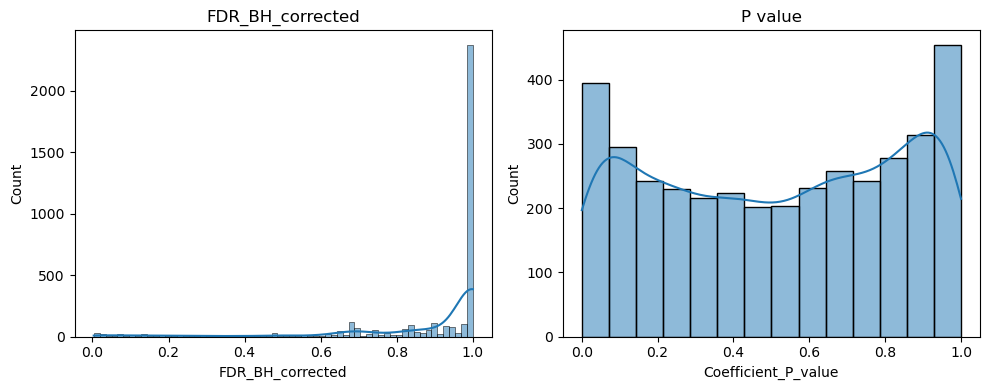

In [10]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [11]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.047449,0.007045,0.000622,0.106529,0.048921,0.054570,0.160429,0.883975,0.102675,0.158143,...,1.217596,1.139883e-06,0.320537,0.277442,0.198148,0.154304,1.534247,1.127486,0.183168,0.323982
Astrocyte,0.157143,0.939073,0.217825,0.126912,1.198364,0.800499,0.031438,0.058748,0.743835,1.592676,...,0.207395,1.908864e-01,0.022193,0.102370,0.085878,0.323457,0.023796,1.236010,0.109693,0.555676
CN_Cholinergic_GABA,0.732618,0.004182,0.112672,0.143768,0.233810,0.061914,0.094059,0.367846,0.294997,0.141182,...,1.102319,1.586935e-05,0.821904,0.066905,0.009039,0.022525,0.640153,1.300205,0.048772,0.056075
CN_GABA-Glut,2.294669,0.010834,0.248606,0.024016,0.432809,0.084563,0.081902,0.951423,0.408388,0.152820,...,1.255903,2.395515e-07,1.128452,0.121615,0.141400,0.190393,1.096765,0.738245,0.126537,0.906243
CN_LAMP5-CXCL14_GABA,2.621830,0.006528,0.087002,0.333003,0.027005,0.095411,0.150895,1.491148,0.301711,0.124345,...,2.435147,7.049515e-04,0.686848,0.188092,0.069517,0.073482,1.399186,0.576958,0.013031,0.223900


In [12]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.756543,0.999999,0.999999,...,0.646739,0.999999,0.999999,0.999999,0.999999,0.999999,0.480979,0.686168,0.999999,0.999999
Astrocyte,0.999999,0.731994,0.999999,0.999999,0.650780,0.816758,0.999999,0.999999,0.835430,0.462745,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.644516,0.999999,0.927112
CN_Cholinergic_GABA,0.837553,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,...,0.688261,0.999999,0.808404,0.999999,0.999999,0.999999,0.884914,0.620727,0.999999,0.999999
CN_GABA-Glut,0.162619,0.999999,0.999999,0.999999,0.984548,0.999999,0.999999,0.724245,0.999999,0.999999,...,0.637878,0.999999,0.686168,0.999999,0.999999,0.999999,0.688261,0.837553,0.999999,0.740269
CN_LAMP5-CXCL14_GABA,0.107550,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.496179,0.999999,0.999999,...,0.136137,0.999999,0.857938,0.999999,0.999999,0.999999,0.557418,0.908214,0.999999,0.999999


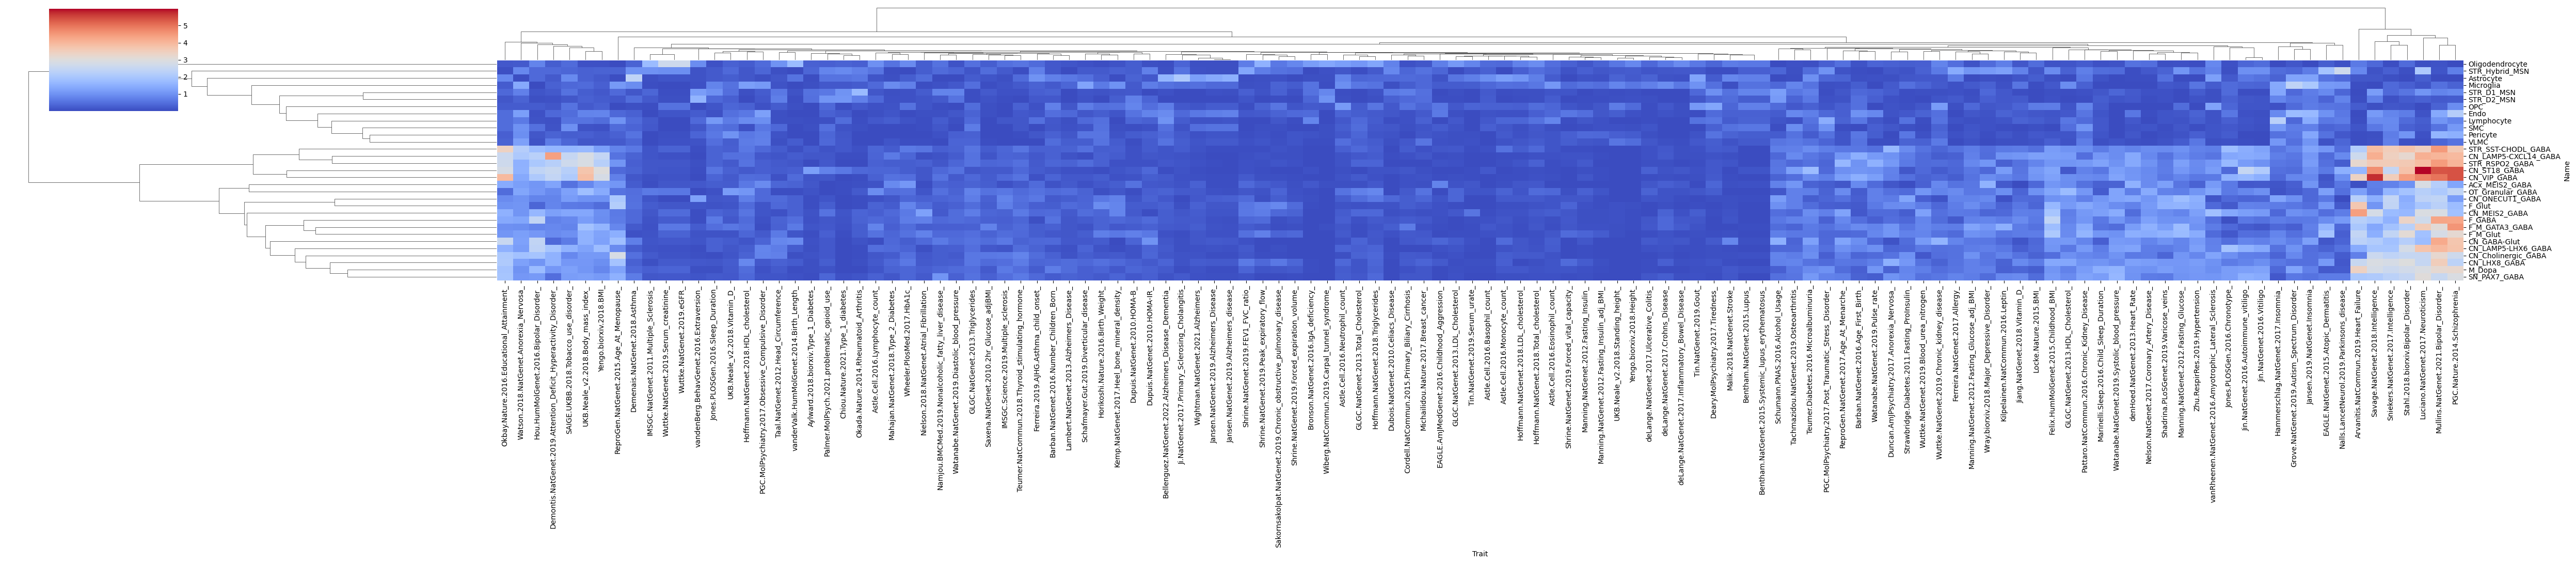

In [13]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(50, 11))

plt.show()
g.savefig(f'output/{run_id}.pdf')

In [14]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

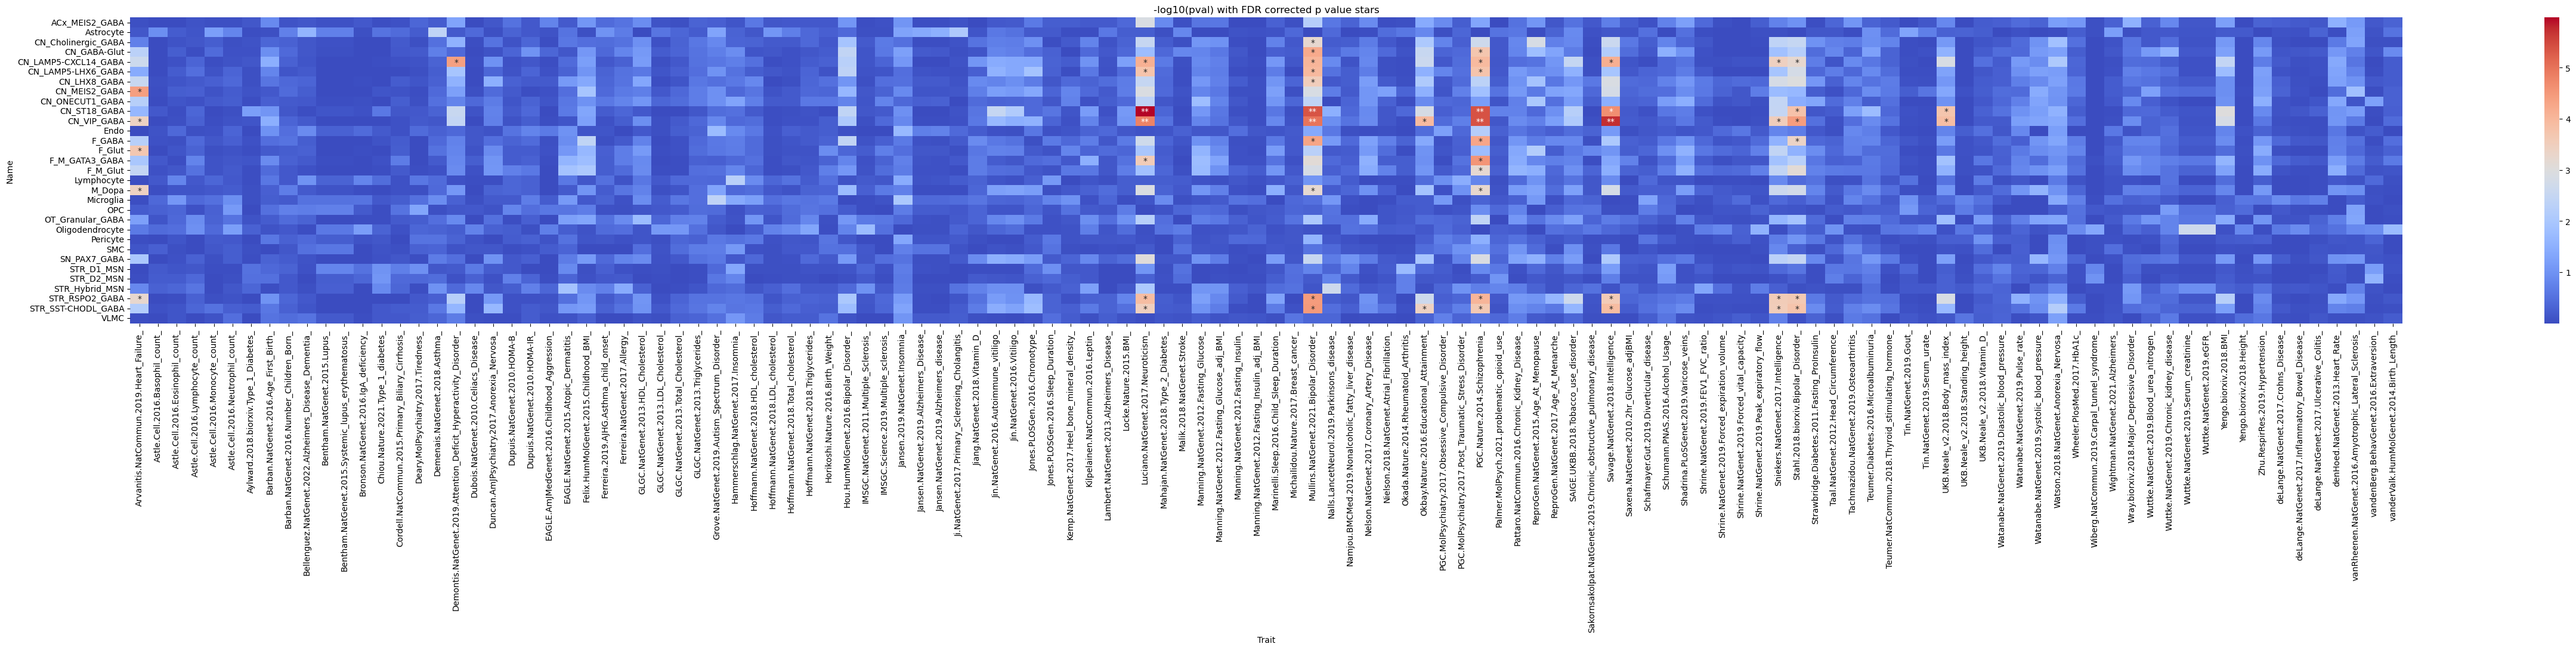

In [15]:
stars = fdr_modified_df.applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(50, 11))
sns.heatmap(modified_df, annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_FDR_corrected.pdf')
plt.show()

